In [1]:
from random import randint
from qiskit.providers.jobstatus import JobStatus
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit import *
from qiskit.circuit.library import *
from time import sleep
import math
import sys
from qiskit.aqua.algorithms import AmplitudeEstimation

In [2]:
%matplotlib inline

In [15]:

backend = Aer.get_backend('qasm_simulator')
def execute_qc(qc, verbose=True, shots=1024):
    job = execute(qc, backend, shots=shots)

    while job.status() is not JobStatus.DONE:
        if verbose:
            print("Job status:", job.status()) 
        sleep(5)
    

    result = job.result()
    if verbose:
        print(result.get_counts())
        plot_histogram(result.get_counts(qc))

    return result


def adder(n, gate=True):
    qc = QuantumCircuit(3*n + 1)
    for i in range(n):
        # [a=i, b=n+i, zero=2*n+i, carry_in=3*n] -> [a, b, sum, carry]
        qc.swap(2*n+i, 3*n)
        qc.ccx(i, n+i, 3*n)
        qc.cx(i, n+i)
        qc.ccx(n+i, 2*n+i, 3*n)
        qc.cx(n+i, 2*n+i)
        qc.cx(i, n+i)

    if gate:
        return qc.to_gate()
    else:
        return qc

def output(bits, val): # output `val` in binary using `bits` bits
    qc = QuantumCircuit(bits)

    for i in range(bits):
        if val % 2 == 1:
            qc.x(i)
        val //= 2

    return qc.to_gate()


def output_qubits_needed(trials):
    return math.floor(1 + math.log(trials-1)/math.log(2))

def A_size(bits, trials):
    random_qubits = bits * trials
    sum_qubits = random_qubits - bits
    not_done_size = trials
    output_size = output_qubits_needed(trials)

    return random_qubits + sum_qubits + 1 + not_done_size + output_size

def A(bits, trials, gate=True): # m digits, at most k trials
    random_qubits = bits * trials
    sum_qubits = random_qubits - bits
    not_done_size = trials
    output_size = output_qubits_needed(trials)

    qc = QuantumCircuit(random_qubits + sum_qubits + 1 + not_done_size + output_size)
    random_qubits_start = 0
    sum_qubits_start = random_qubits_start + random_qubits
    carry_qubit = sum_qubits_start + sum_qubits
    not_done_start = carry_qubit + 1
    output_start = not_done_start + not_done_size

    for i in range(not_done_start, not_done_start + not_done_size):
        qc.x(i)

    for i in range(random_qubits):
        qc.h(i)

    cadder = adder(bits).control(1)
    output_v = [j for j in range(output_start, output_start + output_size)]

    for i in range(0, trials-1):
        adder_input = [i*bits + random_qubits_start + j for j in range(bits)] + \
                      [(i-1)*bits + sum_qubits_start + j for j in range(bits)] + \
                      [i*bits + sum_qubits_start + j for j in range(bits)] + \
                      [carry_qubit]
        qc.append(cadder, [not_done_start + i] + adder_input)

        if i > 0:
            qc.append(output(output_size, i).control(2), [not_done_start + i, carry_qubit] + output_v)

        qc.cx(carry_qubit, not_done_start + i + 1)
    
    qc.append(output(output_size, trials-1).control(1), [not_done_start + not_done_size - 1] + output_v)
    
    if gate:
        return qc.to_gate()
    else:
        return qc



In [ ]:

def W(n=2):
    N = 2 ** n
    x = QuantumRegister(2)
    q1 = QuantumRegister(1)
    qc = QuantumCircuit(x, q1)
    for i in range(N):
        _i = i
        for j in range(n - 1, -1, -1):
            if _i % 2 == 0:
                qc.x(x[j])
            _i /= 2
        v1 = math.sqrt(i / N)
        v2 = math.sqrt(1 - i / N)
        theta = -math.acos(v1) * 2
        qc.append(RYGate(theta).control(2), [q for q in x] + [q for q in q1])
        qc.ry(theta, q1[0])
        _i = i
        for j in range(n - 1, -1, -1):
            if _i % 2 == 0:
                qc.x(x[j])
            _i /= 2
    return qc.to_gate()

def _Sx(x, N):
    print(N)
    sys.stdout.flush()
    r = QuantumRegister(N)
    qc = QuantumCircuit(r)
    _x = x
    for i in range(N - 1, -1, -1):
        if _x % 2 == 0:
            qc.x(r[i])
        _x //= 2
    if N == 1:
        qc.z(r[N - 1])
    else:
        print("start")
        qc.append(ZGate().control(N - 1), r)
        print("done")
        sys.stdout.flush()
        # qc.mcrz(math.pi, r[0:N - 1], r[N - 1])
    _x = x
    for i in range(N - 1, -1, -1):
        if _x % 2 == 0:
            qc.x(r[i])
        _x //= 2
    return qc.to_gate()

def _Q(A, x, N):
    A_inv = A.inverse()
    qc = QuantumCircuit(N)
    qc.x(0)
    qc.z(0)
    qc.x(0)
    qc.append(_Sx(x, N), range(N))
    qc.append(A_inv, range(N))
    qc.append(_Sx(0, N), range(N))
    qc.append(A, range(N))
    return qc.to_gate()

def _LambdaM(U, m, N):
    q0 = QuantumRegister(m)
    q1 = QuantumRegister(N)
    qc = QuantumCircuit(q0, q1)
    for j in range(2 ** m):
        _j = j
        for i in range(m - 1, -1, -1):
            if _j % 2 == 0:
                qc.x(q0[i])
            _j /= 2
        qc.append(U.control(m), [i for i in q0] + [i for i in q1])
        _j = j
        for i in range(m - 1, -1, -1):
            if _j % 2 == 0:
                qc.x(q0[i])
            _j /= 2
    return qc.to_gate()

def amplitude_estimation(A, m=1, N=1, x=1):
    qc = QuantumCircuit(m + N, m)
    for i in range(m):
        qc.h(i)
    qc.append(_LambdaM(_Q(A, x, N), m, N), range(m + N))
    for i in range(m):
        qc.h(i)
    qc.measure(range(m), range(m))
    return qc

In [ ]:
def run():
    iterations = 1
    logt = 1
    t = 2 ** logt
    max_trials = 2
    precision = 1
    n = A_size(precision, max_trials)
    k = 2

    def U():
        q0 = QuantumRegister(n - k)
        q1 = QuantumRegister(k)
        q2 = QuantumRegister(1)
        qc = QuantumCircuit(q0, q1, q2)
        qc.append(A(precision, max_trials), [q for q in q0] + [q for q in q1])
        qc.append(W(n=k), [q for q in q1] + [q for q in q2])
        return qc
    
    results = []
    _U = U()
    for i in range(iterations):
        exp = 0
        for x in range(2 ** k):
            # qc = amplitude_estimation(_U, x=(x * 2 + 1), m=logt, N=n + 1)
            # res = execute_qc(qc, verbose=True, shots=1)
            # v = int(list(res.get_counts().keys())[0], 2)

            result = AmplitudeEstimation(n+1, _U, objective_qubits=[n]).run(backend)
            print(result)

            # alpha = pow(math.sin(math.pi * v / t), 2)
            # exp += alpha * alpha * x
        results.append(exp)
    print(results)


def run_bare():
    trials = 3
    precision = 4
    shots = 10_000
    output_size = output_qubits_needed(precision)
    gate = A(precision, trials)
    gate_size = A_size(precision, trials)

    print("gate size:", gate_size)

    qc = QuantumCircuit(gate_size, output_size)
    qc.append(gate, range(gate_size))
    qc.measure(range(gate_size - output_size, gate_size), range(output_size))

    results = execute_qc(qc, shots=shots).get_counts()
    e = 0
    for k in results:
        e += int(k, 2) * results[k]
    e /= shots
    e += 2
    print("e =", e)


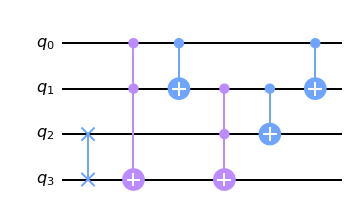

In [22]:
adder(1, False).draw(output='mpl') # a full adder for two bits

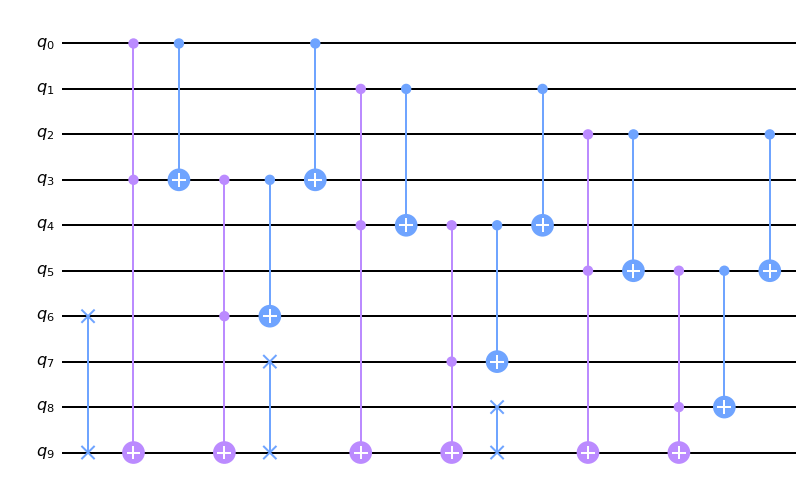

In [24]:
adder(3, False).draw(output='mpl') # a full adder for 2 3-bit numbers

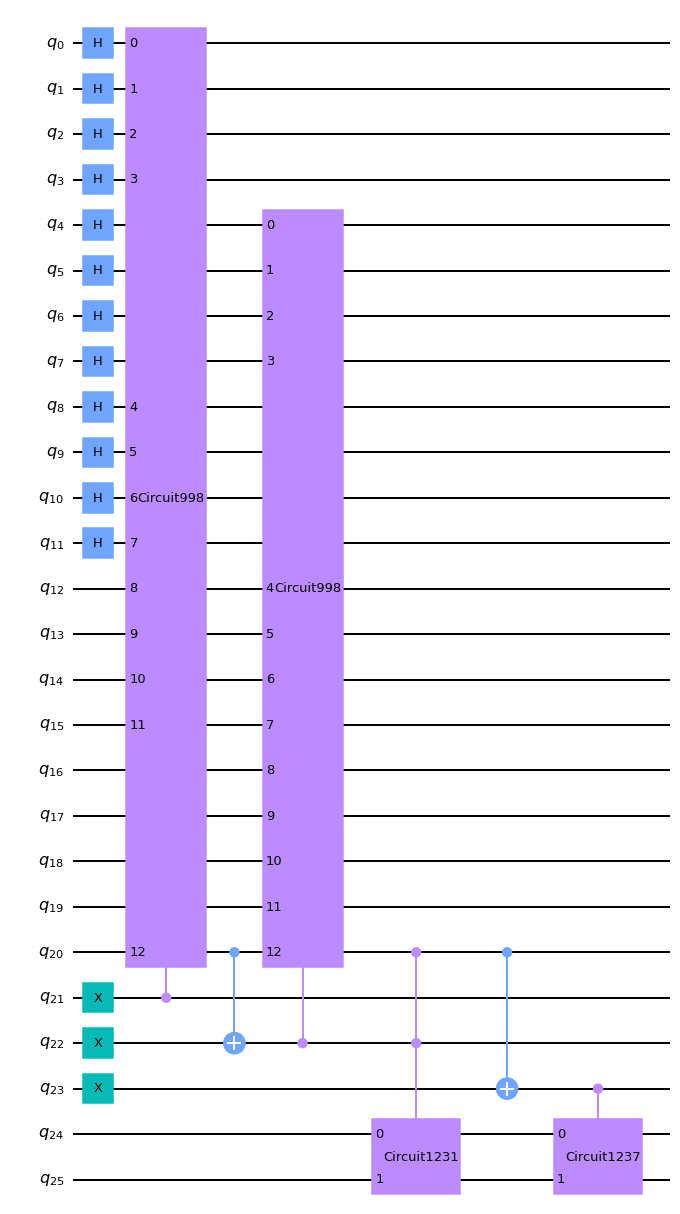

In [16]:

A(4, 3, False).draw(output='mpl') # a Monte Carlo gate

In [23]:
run_bare()

gate size: 26
Job status: JobStatus.INITIALIZING
{'00': 4735, '01': 3366, '10': 1899}
e = 2.7164


In [ ]:
run() # this takes a long time to run